In [1]:
import pycytominer
import matplotlib.pyplot as plt
import pandas as pd
import os
import yaml
import shutil
import sys
sys.path.append("../../../")
import utilssphering

1. Drop features from profile_normalized_negcon.csv.gz.csv.gz
2. Perform feature selection
3. Save this feature selected feature dropped profiles into a new dir
4. Create an evalzoo params file for this dropped profile
5. Run evalzoo
6. plot the mAP for the non-dropped evalzoo paraquet file vs the dropped evalzoo paraquet

In [29]:
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df = match_rep_df[
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["channel_names"].str.contains("RNA"))
    ]
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,True,0.191908,60.000000,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.288099,2014937
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Widefield,4,NaN,1,10,6,...,0.000144,False,0.269727,53.333333,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.320855,2014937
2,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,True,0.269617,62.222222,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.398249,2413350
3,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,...,0.000183,False,0.329074,45.555556,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",18.604651,0.389170,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,...,0.000142,True,0.205121,66.666667,"Actin, DNA, ER, Golgi, Mito, RNA",NaN,"Actin, DNA, ER, Golgi, Mito, RNA",23.255814,0.363114,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,NaN,1,20,6,...,0.000583,False,0.407403,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.480152,1136319
104,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,NaN,1,20,6,...,0.000014,True,0.206867,58.888889,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.318081,1045379
105,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,NaN,1,20,6,...,0.000014,False,0.261967,54.444444,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.360108,1045379
106,Yokogawa_US,Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,NaN,1,40,6,...,0.080201,True,0.181967,54.444444,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.266650,279900


In [30]:
def do_feature_select(plate_df):
    """
    Find the column names that are CellProfiler features. Eg. column names
    that start with "Nuclei" or "Cytoplasm"
    """
    feature_select_features = pycytominer.cyto_utils.infer_cp_features(
        plate_df
    )
    # For all of the cellprofiler features, perform these operations on them
    return pycytominer.feature_select(
        profiles=plate_df,
        features=feature_select_features,
        operation=['variance_threshold','correlation_threshold',
        'drop_na_columns','blocklist']
    )



In [ ]:
profile_parent_dir = "../../../profiles"
parent_save_dir = profile_parent_dir + "_RNA_dropped"

if not os.path.exists(parent_save_dir):
     os.makedirs(parent_save_dir)

for ind, a_vendor in enumerate(match_rep_df["Vendor"].unique()):
        print(f"Processing {a_vendor}")
        vendor_data = match_rep_df.loc[match_rep_df["Vendor"] == a_vendor]
        for a_batch in vendor_data["Batch"].unique():
            batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_negcon.csv.gz")
                load_data = pd.read_csv(data_path)
                drop_cols = "RNA"
                input_columns = load_data.columns
                col_list = [x for x in input_columns if drop_cols not in x]
                try:
                    dropped_df = pd.DataFrame(load_data[col_list])
                    feature_selected_df = do_feature_select(dropped_df)
                except Exception as e:
                    print(f"Error: {e}")

                profile_save_path = os.path.join(parent_save_dir, a_batch, a_plate)

                if not os.path.exists(profile_save_path):
                    os.makedirs(profile_save_path)

                feature_selected_df.to_csv(os.path.join(profile_save_path, a_plate+"_normalized_feature_select_negcon_batch.csv.gz"))

In [40]:
# Check that RNA features were indeed dropped
df = pd.read_csv("../../../profiles_RNA_dropped/Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA_normalized_feature_select_negcon_batch.csv.gz")

[col for col in df.columns if "RNA" in col]

[]

In [32]:
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df = match_rep_df[
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["channel_names"].str.contains("Brightfield", case=False))
    ]
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,...,Size_MB_std,sphering,value_95_replicating,Percent_Replicating,channel_names,brightfield_z_plane_used,feature_channels_found,Percent_Matching,value_95_matching,cell_count
94,Yokogawa_US,Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,NaN,1,10,6,...,0.124906,True,0.218493,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",23.255814,0.356314,2047342
95,Yokogawa_US,Scope1_Yokogawa_US_10X,JUMP-MOA_compound_platemap,BRO0117014_10x,Confocal,4,NaN,1,10,6,...,0.124906,False,0.287125,47.777778,"AGP, BrightField, DNA, ER, Mito, RNA",Z06,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.353686,2047342
102,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,NaN,1,20,6,...,0.000583,True,0.281239,61.111111,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",23.255814,0.430396,1136319
103,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,NaN,1,20,6,...,0.000583,False,0.407403,56.666667,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.480152,1136319
104,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,NaN,1,20,6,...,0.000014,True,0.206867,58.888889,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.318081,1045379
105,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,NaN,1,20,6,...,0.000014,False,0.261967,54.444444,"AGP, BrightField, DNA, ER, Mito, RNA",Z17,"AGP, BrightField, DNA, ER, Mito, RNA",20.930233,0.360108,1045379
106,Yokogawa_US,Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,NaN,1,40,6,...,0.080201,True,0.181967,54.444444,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",18.604651,0.266650,279900
107,Yokogawa_US,Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,NaN,1,40,6,...,0.080201,False,0.370124,45.555556,"AGP, BrightField, DNA, ER, Mito, RNA",Z08,"AGP, BrightField, DNA, ER, Mito, RNA",13.953488,0.455924,279900


In [ ]:
profile_parent_dir = "../../../profiles"
parent_save_dir = profile_parent_dir + "_BrightField_dropped"

if not os.path.exists(parent_save_dir):
     os.makedirs(parent_save_dir)

for ind, a_vendor in enumerate(match_rep_df["Vendor"].unique()):
        print(f"Processing {a_vendor}")
        vendor_data = match_rep_df.loc[match_rep_df["Vendor"] == a_vendor]
        for a_batch in vendor_data["Batch"].unique():
            batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_negcon.csv.gz")
                load_data = pd.read_csv(data_path)
                drop_cols = "BrightField"
                input_columns = load_data.columns
                col_list = [x for x in input_columns if drop_cols.casefold() not in x.casefold()]
                try:
                    dropped_df = pd.DataFrame(load_data[col_list])
                    feature_selected_df = do_feature_select(dropped_df)
                except Exception as e:
                    print(f"Error: {e}")

                profile_save_path = os.path.join(parent_save_dir, a_batch, a_plate)

                if not os.path.exists(profile_save_path):
                    os.makedirs(profile_save_path)

                feature_selected_df.to_csv(os.path.join(profile_save_path, a_plate+"_normalized_feature_select_negcon_batch.csv.gz"))

In [41]:
df = pd.read_csv("../../../profiles_BrightField_dropped/Scope1_Yokogawa_US_10X/BRO0117014_10x/BRO0117014_10x_normalized_feature_select_negcon_batch.csv.gz")

[col for col in df.columns if "BrightField" in col]

[]

In [55]:

def make_params(df, drop=None):
    with open("../../../evalzoo/within_matches.yml") as f:
        match_yaml = yaml.safe_load(f)

    with open("../../../evalzoo/within_replicates.yml") as f:
        rep_yaml = yaml.safe_load(f)

    for batch, grouped_df in df.groupby("Batch")[["Batch", "Assay_Plate_Barcode"]]:
        plates = grouped_df["Assay_Plate_Barcode"].tolist()

        out_rep_yaml = rep_yaml
        out_rep_yaml["experiment"]["data_path"] = f"/input/profiles{drop if drop is not None else ''}/{batch}"
        out_rep_yaml["experiment"]["plates"] = plates

        out_match_yaml = match_yaml
        out_match_yaml["experiment"]["data_path"] = f"/input/profiles{drop if drop is not None else ''}/{batch}"
        out_match_yaml["experiment"]["plates"] = plates

        save_dir = os.path.join(f"params{drop if drop is not None else ''}", batch)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        with open(os.path.join(save_dir, f'{batch}_replicates_config.yaml'), 'w') as f:
            yaml.dump(out_rep_yaml, f, sort_keys=False)

        with open(os.path.join(save_dir, f'{batch}_matches_config.yaml'), 'w') as f:
            yaml.dump(out_match_yaml, f, sort_keys=False)


match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")

make_params(df = match_rep_df[
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["channel_names"].str.contains("RNA"))
    ],
    drop="_RNA_dropped")

make_params(df = match_rep_df[
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["channel_names"].str.contains("Brightfield", case=False))
    ], 
    drop="_BrightField_dropped")



In [58]:

def postprocess_evalzoo(results_dir):
    for result_folder in os.listdir(results_dir):
        print(os.path.join(results_dir, result_folder))
        if ".DS_Store" not in result_folder:
            with open(os.path.join(results_dir, result_folder, "params.yaml")) as f:
                param_file = yaml.safe_load(f)
            batch = param_file["experiment"]["data_path"].split("/")[-1]
            # Don't try to process a folder that has already been processed
            if batch not in result_folder:
                os.remove(os.path.join(results_dir, result_folder, "profiles.parquet"))
                os.remove(os.path.join(results_dir, result_folder, "metrics_plot_level_1_pvalue.html"))
                os.remove(os.path.join(results_dir, result_folder, "metrics_plot_level_1_qvalue.html"))
                shutil.rmtree(os.path.join(results_dir, result_folder, "metrics_plot_level_1_pvalue_files"))
                shutil.rmtree(os.path.join(results_dir, result_folder, "metrics_plot_level_1_qvalue_files"))
                rep_or_non_rep = param_file["experiment"]["background_type"]
                shutil.move(os.path.join(results_dir, result_folder), os.path.join(results_dir, batch+"_"+rep_or_non_rep))

postprocess_evalzoo("../../../data/results_RNA_dropped/results/")
postprocess_evalzoo("../../../data/results_BrightField_dropped/results/")


../../../data/results_RNA_dropped/results/a11d714a
../../../data/results_RNA_dropped/results/9bb3a2d4
../../../data/results_RNA_dropped/results/e71dd487
../../../data/results_RNA_dropped/results/3a496d2d
../../../data/results_RNA_dropped/results/85f59eec
../../../data/results_RNA_dropped/results/b78ef6c8
../../../data/results_RNA_dropped/results/ee27508b
../../../data/results_RNA_dropped/results/a8e60cf0
../../../data/results_RNA_dropped/results/00ed98f6
../../../data/results_RNA_dropped/results/6752f1e2
../../../data/results_RNA_dropped/results/b1dc5e10
../../../data/results_RNA_dropped/results/d44cb0e7
../../../data/results_RNA_dropped/results/ced2d093
../../../data/results_RNA_dropped/results/ba1fd411
../../../data/results_RNA_dropped/results/7f136e02
../../../data/results_RNA_dropped/results/bc2e7c7a
../../../data/results_RNA_dropped/results/c687108f
../../../data/results_RNA_dropped/results/ff632e15
../../../data/results_RNA_dropped/results/8fb21638
../../../data/results_RNA_dropp

In [59]:
def combine_evalzoo_metrics(match_rep_df: pd.DataFrame, evalzoo_dir: str = "results/results"):
    # Add Batch and Metadata_Plate since we need to check the presence of a
    # string in them later, and you can't check them if they don't exist
    output_df = pd.DataFrame({"Batch": [], "Metadata_Plate": []})
    for ind, row in match_rep_df.iterrows():
        # Need to do some check that this row has not already been processed (so
        # we don't add it twice)
        if not (row["Batch"] in output_df["Batch"].values and row["Assay_Plate_Barcode"] in output_df["Metadata_Plate"].values):
            ref_metric_path = os.path.join(evalzoo_dir, row["Batch"]+"_ref", f"metrics_level_1_ref.parquet")
            non_rep_metric_path = os.path.join(evalzoo_dir, row["Batch"]+"_non_rep", f"metrics_level_1_non_rep.parquet")

            ref_metric_df = pd.read_parquet(ref_metric_path)
            non_rep_metric_df = pd.read_parquet(non_rep_metric_path)

            # Since we are going to use the metric_type to differentiate between ref
            # and non_rep, remove this information from the feature names
            # ref_metric_df = ref_metric_df.rename(lambda x: x + "_ref" if "sim_" in x else x, axis=1)
            # non_rep_metric_df = non_rep_metric_df.rename(lambda x: x + "_non_rep" if "sim_" in x else x, axis=1)

            ref_metric_df = ref_metric_df.rename(lambda x: x.replace("_ref", "") if "sim_" in x else x, axis=1)
            non_rep_metric_df = non_rep_metric_df.rename(lambda x: x.replace("_non_rep", "") if "sim_" in x else x, axis=1)

            # Add cols
            (
                ref_metric_df["Vendor"], 
                ref_metric_df["Batch"], 
                ref_metric_df["Magnification"], 
                ref_metric_df["Binning"], 
                ref_metric_df["z_plane"], 
                ref_metric_df["metric_type"]
                ) = (
                row["Vendor"], 
                row["Batch"], 
                row["Magnification"], 
                row["Binning"], 
                row["z_plane"], 
                "ref"
            )

            (
                non_rep_metric_df["Vendor"], 
                non_rep_metric_df["Batch"],
                non_rep_metric_df["Magnification"], 
                non_rep_metric_df["Binning"], 
                non_rep_metric_df["z_plane"], 
                non_rep_metric_df["metric_type"]
                ) = (
                row["Vendor"], 
                row["Batch"], 
                row["Magnification"], 
                row["Binning"], 
                row["z_plane"], 
                "non_rep"
                )
            
            # Cast some columns to int
            ref_metric_df["Magnification"] = ref_metric_df["Magnification"].astype("Int64")
            ref_metric_df["Binning"] = ref_metric_df["Binning"].astype("Int64")
            ref_metric_df["z_plane"] = ref_metric_df["z_plane"].astype("Int64")

            non_rep_metric_df["Magnification"] = non_rep_metric_df["Magnification"].astype("Int64")
            non_rep_metric_df["Binning"] = non_rep_metric_df["Binning"].astype("Int64")
            non_rep_metric_df["z_plane"] = non_rep_metric_df["z_plane"].astype("Int64")


            output_df = pd.concat([output_df, ref_metric_df, non_rep_metric_df], axis=0)

    return output_df

match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df = match_rep_df[
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["channel_names"].str.contains("RNA"))
    ]
evalzoo_combined = combine_evalzoo_metrics(match_rep_df, "../../../data/results_RNA_dropped/results/")
evalzoo_combined.to_parquet("rna-drop-evalzoo-combined.parquet", index=False)

match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df = match_rep_df[
    (~match_rep_df["Batch"].str.contains("siteSub")) &
    (match_rep_df["channel_names"].str.contains("Brightfield", case=False))
    ]
evalzoo_combined = combine_evalzoo_metrics(match_rep_df, "../../../data/results_BrightField_dropped/results/")
evalzoo_combined.to_parquet("brightfield-drop-evalzoo-combined.parquet", index=False)

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_57002/987030368.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (row["Batch"] in output_df["Batch"].values and row["Assay_Plate_Barcode"] in output_df["Metadata_Plate"].values):
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_57002/987030368.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (row["Batch"] in output_df["Batch"].values and row["Assay_Plate_Barcode"] in output_df["Metadata_Plate"].values):


In [9]:
all_channels_df = pd.read_parquet("../../../data/evalzoo_metrics_combined.paraquet")

brightfield_drop_df = pd.read_parquet("brightfield-drop-evalzoo-combined.parquet")

# Keep only the profiles that are tested in brightfield
subset_all_df = all_channels_df[
    (all_channels_df["Metadata_Plate"].isin(brightfield_drop_df["Metadata_Plate"])) & 
    (~all_channels_df["Batch"].str.contains("siteSub"))
     ].copy()

subset_all_df.loc[:, "dropout"] = "All Channels"
brightfield_drop_df.loc[:, "dropout"] = "No BrightField"

print(subset_all_df.shape, brightfield_drop_df.shape)

all_df = pd.concat([subset_all_df, brightfield_drop_df], axis=0)
all_df

(532, 38) (532, 38)


,Batch,Metadata_Plate,Metadata_pert_iname,Metadata_reference_or_other,sim_scaled_mean_i_mean_i,sim_scaled_mean_i_median_i,sim_scaled_median_i_mean_i,sim_scaled_median_i_median_i,sim_ranked_relrank_mean_i_mean_i,sim_ranked_relrank_mean_i_median_i,...,sim_retrieval_average_precision_i_nlog10pvalue_mean_i,sim_retrieval_average_precision_i_nlog10pvalue_median_i,sim_retrieval_average_precision_i_nlog10qvalue_mean_i,Vendor,Magnification,Binning,z_plane,metric_type,Metadata_moa,dropout
6420,Scope1_Yokogawa_US_10X,BRO0117014_10x,A-366,pert,-0.212382,-0.023707,0.321436,0.325855,0.541667,0.513889,...,0.369927,0.402050,0.288114,Yokogawa_US,10,1,12,ref,None,All Channels
6421,Scope1_Yokogawa_US_10X,BRO0117014_10x,ABT-737,pert,2.660274,2.745765,2.524185,2.584635,0.065972,0.048611,...,3.284809,3.849528,2.761931,Yokogawa_US,10,1,12,ref,None,All Channels
6422,Scope1_Yokogawa_US_10X,BRO0117014_10x,AMG-925,pert,3.106238,3.508187,2.629808,2.808275,0.086806,0.076389,...,2.881854,3.261483,2.459091,Yokogawa_US,10,1,12,ref,None,All Channels
6423,Scope1_Yokogawa_US_10X,BRO0117014_10x,AMG900,pert,5.725393,5.905127,5.799696,5.978359,0.041667,0.041667,...,4.000043,4.000043,3.346831,Yokogawa_US,10,1,12,ref,None,All Channels
6424,Scope1_Yokogawa_US_10X,BRO0117014_10x,APY0201,pert,8.303124,9.022150,8.770587,9.586999,0.041667,0.041667,...,4.000043,4.000043,3.346831,Yokogawa_US,10,1,12,ref,None,All Channels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,0.442451,0.442451,0.442451,0.442451,0.448864,0.448864,...,0.409372,0.409372,0.267266,Yokogawa_US,40,1,12,non_rep,pyruvate dehydrogenase kinase inhibitor,No BrightField
528,Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,0.534133,0.534133,0.534133,0.534133,0.272727,0.272727,...,0.710201,0.710201,0.346536,Yokogawa_US,40,1,12,non_rep,smoothened receptor agonist,No BrightField
529,Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,0.511701,0.511701,0.511701,0.511701,0.380682,0.380682,...,0.509829,0.509829,0.291334,Yokogawa_US,40,1,12,non_rep,tricyclic antidepressant,No BrightField
530,Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,None,pert,0.553910,0.553910,0.553910,0.553910,0.204545,0.204545,...,0.746380,0.746380,0.346536,Yokogawa_US,40,1,12,non_rep,tumor necrosis factor production inhibitor,No BrightField


The pvalue is: 0.214
The pvalue is: 0.21397447601056474


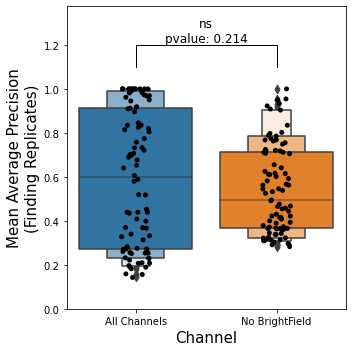

In [10]:
metric_type = "ref"
x = "dropout"
y = "sim_retrieval_average_precision_i_mean_i"

plot_df = all_df[
    (~all_df["Batch"].str.contains("siteSub"))
]

plot_df = plot_df[plot_df["metric_type"] == metric_type].groupby(["Metadata_pert_iname", x]).mean().reset_index()

fig, ax = plt.subplots(figsize=(5,5))

plot = utilssphering.plot_two_distributions(
    plot_df,
    x,
    y,
    xlabel="Channel",
    ylabel="Mean Average Precision\n(Finding Replicates)",
    include_pval=True,
    ax=ax,
    fig=fig
)

plot.savefig("(S10A)-mAP_replicates-brightfield-drop.png", dpi=300)

The pvalue is: 0.583
The pvalue is: 0.5829098320472328


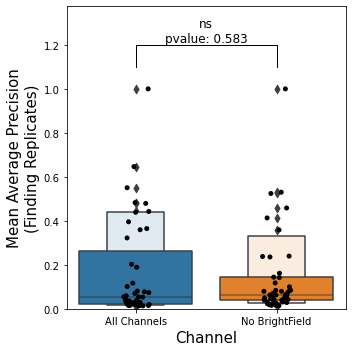

In [19]:
metric_type = "non_rep"
x = "dropout"
y = "sim_retrieval_average_precision_i_mean_i"

plot_df = all_df[
    (~all_df["Batch"].str.contains("siteSub"))
]

plot_df = plot_df[plot_df["metric_type"] == metric_type].groupby(["Metadata_moa", x]).mean().reset_index()

fig, ax = plt.subplots(figsize=(5,5))

plot = utilssphering.plot_two_distributions(
    plot_df,
    x,
    y,
    xlabel="Channel",
    ylabel="Mean Average Precision\n(Finding Replicates)",
    include_pval=True,
    ax=ax,
    fig=fig
)

plot.savefig("(S10B)-mAP_matches-brightfield-drop.png", dpi=300)

In [6]:
all_channels_df = pd.read_parquet("../../../data/evalzoo_metrics_combined.paraquet")

rna_drop_df = pd.read_parquet("rna-drop-evalzoo-combined.parquet")

# Keep only the profiles that are tested in brightfield
subset_all_df = all_channels_df[
    (all_channels_df["Metadata_Plate"].isin(rna_drop_df["Metadata_Plate"])) & 
    (~all_channels_df["Batch"].str.contains("siteSub"))
     ].copy()

subset_all_df.loc[:, "dropout"] = "All Channels"
rna_drop_df.loc[:, "dropout"] = "No RNA"

print(subset_all_df.shape, rna_drop_df.shape)

all_df = pd.concat([subset_all_df, rna_drop_df], axis=0)
all_df

The pvalue is: 0.019
The pvalue is: 0.01904534181158718


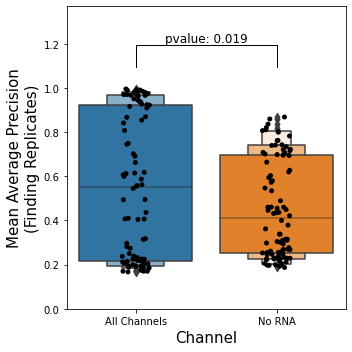

In [3]:
metric_type = "ref"
x = "dropout"
y = "sim_retrieval_average_precision_i_mean_i"

plot_df = all_df[
    (~all_df["Batch"].str.contains("siteSub"))
]

plot_df = plot_df[plot_df["metric_type"] == metric_type].groupby(["Metadata_pert_iname", x]).mean().reset_index()

fig, ax = plt.subplots(figsize=(5,5))

plot = utilssphering.plot_two_distributions(
    plot_df,
    x,
    y,
    xlabel="Channel",
    ylabel="Mean Average Precision\n(Finding Replicates)",
    include_pval=True,
    ax=ax,
    fig=fig
)

plot.savefig("(S10C)-mAP_replicates-RNA-drop.png", dpi=300)

The pvalue is: 0.973
The pvalue is: 0.9728963248888831


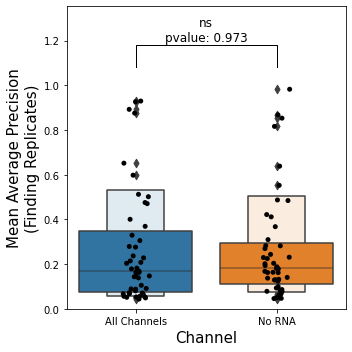

In [5]:
metric_type = "non_rep"
x = "dropout"
y = "sim_retrieval_average_precision_i_mean_i"

plot_df = all_df[
    (~all_df["Batch"].str.contains("siteSub"))
]

plot_df = plot_df[plot_df["metric_type"] == metric_type].groupby(["Metadata_moa", x]).mean().reset_index()

fig, ax = plt.subplots(figsize=(5,5))

plot = utilssphering.plot_two_distributions(
    plot_df,
    x,
    y,
    xlabel="Channel",
    ylabel="Mean Average Precision\n(Finding Replicates)",
    include_pval=True,
    ax=ax,
    fig=fig
)

plot.savefig("(S10D)-mAP_matches-RNA-drop.png", dpi=300)